In [31]:
import pandas as pd
import ee
import geemap
import ipyleaflet # to show the map in the notebook

## Packages required for using Dynamic World in a Jupyter Notebook

### How to install the EarthEngine Python package?

`EarthEngine`: 

Installation Tutorial: https://developers.google.com/earth-engine/guides/python_install-conda#mac_6

This tutorial requires the installation of Google Cloud: using the following command:
    
```bash
curl https://sdk.cloud.google.com | bash
```

To authenticate, you should: `earthengine authenticate` as the ee.Authenticate() function is not working. (it only works in Google Colab Notebooks)


### How to authenticate? 
Instructions are here: https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup


### How to install the earthengine command-line tool in the Google Cloud Shell:
        
```bash
curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py && python get-pip.py --user
pip install earthengine-api --upgrade --user
echo 'export PATH="$HOME/.local/bin:$PATH"' >> ~/.bashrc
source ~/.bashrc
```

You can validate this installation by using `earthengine authenticate` in the Google Cloud Shell.
            
- `GeeMap`: 


In [32]:
ee.Initialize(project="jpmorgancapstone")

In [33]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

In [34]:
# Set the region of interest by simply drawing a polygon on the map
region = Map.user_roi
if region is None:
    region = ee.Geometry.BBox(-96.8745,29.0542,-94.1144,30.6785)

Map.centerObject(region)

In [35]:
# Extract Dynamic World Data for year 2019
start_date = '2019-01-01'
end_date = '2020-01-01'

### What are the bands?

The bands in the s2VisParams variable refer to the Sentinel-2 Harmonized dataset's specific bands used for visualization. Sentinel-2 data has 13 spectral bands, but we typically use a combination of three bands to visualize the data in RGB (red, green, blue) format. In this case, the bands used are:

'B4': The red band (band 4) with a central wavelength of 665 nm and a resolution of 10 meters.
'B3': The green band (band 3) with a central wavelength of 560 nm and a resolution of 10 meters.
'B2': The blue band (band 2) with a central wavelength of 490 nm and a resolution of 10 meters.
These three bands are used to create a true-color composite image that closely resembles how the human eye would perceive the landscape.

The min and max values in the s2VisParams are the minimum and maximum pixel values for visualization. These values are used to scale the brightness of the image. In this case, the pixel values are scaled between 0 and 3000, which is a common choice for Sentinel-2 data to enhance the contrast and improve the overall appearance of the image.

In [36]:
# Create a Sentinel-2 image composite
image = geemap.dynamic_world_s2(region, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(image, vis_params, 'Sentinel-2 image')

In [37]:
# Create Dynamic World land cover composite
landcover = geemap.dynamic_world(region, start_date, end_date, return_type='probability')
Map.addLayer(landcover, {}, 'Land Cover')

In [38]:
landcover

# plot the landcover image
# print(landcover)

In [40]:
# # Add legend to the map
# Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
# Map


In [10]:
landcover

## Test 2  - Matrix Extraction

In [8]:
import ee
import folium
from IPython.display import Image
import geemap

### Image extraction from the Google Earth Engine

In [17]:
ee.Initialize(project="jpmorgancapstone")

In [18]:
region_large = ee.Geometry.BBox(-104.99,25.08,-85.09,34.93)
region_small = ee.Geometry.BBox(-95.9134,29.2082,-94.4339,30.0581)#-96.8745, 29.0542, -94.1144, 30.6785)
year = 2019

In [22]:
#Initialize the map
Map = geemap.Map()
Map.add_basemap('HYBRID')

# Set the region of interest by simply drawing a polygon on the map
Map.centerObject(region_small)

In [23]:
startDate = '2019-01-01'
endDate = '2020-01-01'

s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
             .filterDate(startDate, endDate) \
             .filterBounds(region_small) \
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35)) 

#### Why do we get 648 images?

Yes, I understand why this query returns 648 images. The Sentinel-2 satellite system consists of two satellites (Sentinel-2A and Sentinel-2B), which together provide a revisit time of 5 days at the equator. The query you provided filters the Sentinel-2 Harmonized dataset for images within a specified date range (from January 1, 2019, to January 1, 2020) and region, and with a cloud cover percentage less than 35%.

In the given region and time period, 648 images satisfy these conditions. It is important to note that Sentinel-2 images are divided into granules or tiles, each covering a specific area on the Earth's surface. The query returns all the images of the specified region, which may include overlapping or adjacent granules. The total number of images returned may vary depending on the size of the region, the time period, and the cloud cover conditions.

In [24]:
# get the first image out of the 648 satellite images
s2Image = ee.Image(s2.first())

# Plot this first image
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(s2Image, vis_params, 'Sentinel-2 image')
Map

Map(center=[29.6331500009872, -95.17365000000001], controls=(WidgetControl(options=['position', 'transparent_b…

## Label extraction from Dynamic World

In [25]:
imageId = s2Image.get('system:index')
# print(imageId)

In [26]:
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
             .filter(ee.Filter.eq('system:index', imageId))

dwImage = ee.Image(dw.first())
print(dwImage)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
                    "constantValue": "GOOGLE/DYNAMICWORLD/V1"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "system:index"
                  },
                  "rightValue": {
                    "functionInvocationValue": {
                      "functionName": "Element.get",
                      "arguments": {
                        "ob

In [27]:
classification = dwImage.select('label')
classification

#### Export this image

In [19]:
# import time

# export_params = {
#     'image': classification,
#     'description': 'example_image_export',
#     'folder': '/ge_exports/',  # Google Drive folder name
#     'scale': 10,  # Resolution in meters
#     'region': region,
#     'fileFormat': 'GeoTIFF',
#     'maxPixels': 1e9,  # Increase this value if you encounter an error due to the pixel limit
# }

# export_task = ee.batch.Export.image.toDrive(**export_params)
# export_task.start()

In [28]:
classification = dwImage.select('label')
dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
}

Map.addLayer(classification, dwVisParams, 'Classified Image')
Map

Map(bottom=54531.0, center=[29.6331500009872, -95.17365000000001], controls=(WidgetControl(options=['position'…

## Extract probability values

In [21]:
probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]

probabilityImage = dwImage.select(probabilityBands)

# Create the image with the highest probability value at each pixel.
top1Probability = probabilityImage.reduce(ee.Reducer.max())

In [22]:
probabilityImage

In [23]:
top1Probability

## Read a TIFF Image in Python

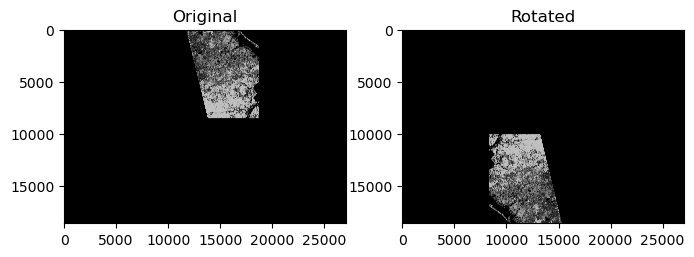

In [27]:
import imageio
import numpy as np

# Load the image
image = imageio.imread('../Images/example_image_export.tif')

# Rotate the image by 180 degrees
rotated_image = np.rot90(image, 2)

# Display the original and rotated images side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(rotated_image, cmap='gray')
axs[1].set_title('Rotated')
plt.show()
